## Лабораторная работа 0-1 по курсу "Машинное обучение" 

| Студент | Цыкин  |
|---------|--------|
| Группа  | 301    |

## Подключение библиотек

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_curve, classification_report, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc 
import joblib

В этой части я подключаю необходимые библиотеки для реализации работы

## Загрузка данных

In [3]:
df = pd.read_csv('Data_classified_phase_.csv')
df.shape

(15388, 28)

In [4]:
df.columns

Index(['Kpmag', 'numax', 'e_numax', 'Delnu', 'e_Delnu', 'A', 'e_A', 'Width',
       'e_Width', 'Teff', 'e_Teff', 'log(g)', 'e_log(g)', '[Fe/H]', 'e_[Fe/H]',
       'NoCorM', 'e_NoCorM', 'NoCorR', 'e_NoCorR', 'RGBcorM', 'e_RGBcorM',
       'RGBcorR', 'e_RGBcorR', 'ClcorM', 'e_ClcorM', 'ClcorR', 'e_ClcorR',
       'Phase'],
      dtype='object')

## Pipeline

In [5]:
from sklearn.pipeline import Pipeline

Здесь я описал функцию, которая преобразает данные, как это было сделанно в 0 лабораторной работе. Но некоторые есть исключения, потерянные данные я поменял на среднее значения звезд первого класса, а так же нормировка данных.

In [6]:
def trans(data):
    df = data.copy()
    arr = []
    for column in df.columns:
        if df.dtypes[column] == 'object':
            arr.append(column)
    for i in range(1, 20):    
        df[df == i*' '] = np.nan
    for i in arr:
        df[i] = pd.to_numeric(df[i])
    df_1 = df[df['Phase'] == 1]
    for i in arr:    
        df[i] = df[i].fillna(df[i].mean())
    
    par = ["NoCorM", "e_NoCorM", "NoCorR", "e_NoCorR",  "RGBcorM", "e_RGBcorM", "RGBcorR", "e_RGBcorR", "Phase"]
    df = df.drop(par, axis = 1)
    df=(df-df.mean())/df.std()
    
    return df
    
class SpInpTransformer():
    def __init__(self,f):
        self.func = f

    def transform(self, input_df, **transform_params):
        return self.func(input_df)
  
    def fit(self, X, y = None, **fit_params):
        return self

In [7]:
X = df

In [8]:
df_y = df.copy()
y = df_y['Phase']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

## Линейная регрессия

In [10]:
#коробочный классификатор
from sklearn.linear_model import LinearRegression

In [11]:
#своя реализация
class my_LinearRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.01):
        self.lr = lr
        self.iters = 1500
        self.w = None
        self.b = None
    
    def fit(self, X, y):
        samples, features = X.shape
        self.w = np.zeros(features)
        self.b = 0
        
        for i in range(self.iters):
            pred = np.dot(X, self.w) + self.b
            dw = 1/samples * np.dot(X.T, (pred - y))
            db = 1/samples * np.sum(pred - y)
            self.w -= self.lr * dw
            self.b -= self.lr * db
    
    def predict(self, X):
        pred = np.dot(X, self.w) + self.b
        y_pred = np.where(pred <=  1.5, 1, 2)
            
        return y_pred

Составление Pipeline'ов для моего классификатора и коробочного классификатора линейной регрессии

In [12]:
my_clf = Pipeline(
    [
        ("trans", SpInpTransformer(trans)),
        ("model", my_LinearRegression())
    ])

clf = Pipeline(
    [
        ("trans", SpInpTransformer(trans)),
        ("model", LinearRegression())
    ])

Моя модель

Accuracy -  0.898635477582846
recall_score -  0.8716612377850163
precision -  0.9208534067446662


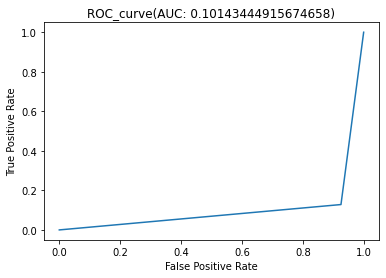

confusion matrix:


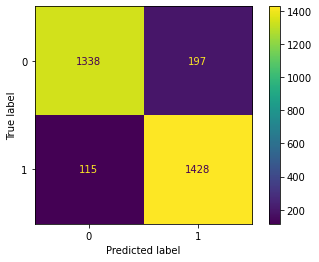

In [13]:
my_clf.fit(X_train, y_train)
y_pred = my_clf.predict(X_test)
print('Accuracy - ', accuracy_score(y_test, y_pred))
print('recall_score - ', recall_score(y_test, y_pred))
print('precision - ', precision_score(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)  
AUC = auc(fpr, tpr) 
plt.plot(fpr, tpr)  
plt.title('ROC_curve' + '(AUC: ' + str(AUC) + ')' )  
plt.ylabel('True Positive Rate')  
plt.xlabel('False Positive Rate')  
plt.show()
print('confusion matrix:')
matrix = confusion_matrix(y_test, y_pred)
plot = ConfusionMatrixDisplay(confusion_matrix=matrix)
plot.plot()

Коробочная модель линейной регрессии

Accuracy -  0.9145549057829759
recall_score -  0.8775244299674267
precision -  0.9472573839662447


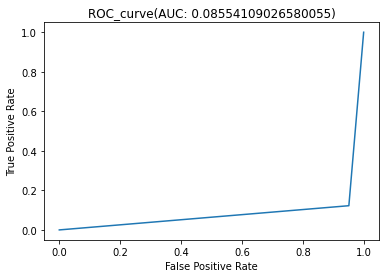

confusion matrix:


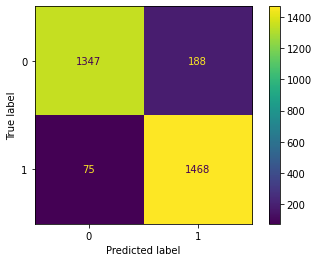

In [14]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred = np.where(y_pred <=  1.5, 1, 2)
print('Accuracy - ', accuracy_score(y_test, y_pred.astype(int)))
print('recall_score - ', recall_score(y_test, y_pred.astype(int)))
print('precision - ', precision_score(y_test, y_pred.astype(int)))
fpr, tpr, thresholds = roc_curve(y_test, y_pred.astype(int), pos_label=1)  
AUC = auc(fpr, tpr) 
plt.plot(fpr, tpr)  
plt.title('ROC_curve' + '(AUC: ' + str(AUC) + ')' )  
plt.ylabel('True Positive Rate')  
plt.xlabel('False Positive Rate')  
plt.show()
print('confusion matrix:')
matrix = confusion_matrix(y_test, y_pred.astype(int))
plot = ConfusionMatrixDisplay(confusion_matrix=matrix)
plot.plot()

Как можно отметить, результат коробочного классификатора лучше моего. Дальше попробуем определить наилушие параметры для классификатора. Не разобрался с использованием GridsearchCV для линейной регрессии, поэтому реализовал сам.

In [15]:
###GridsearchCV
param = []
lr = [1, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01]
for i in lr:
    my_clf = Pipeline(
    [
        ("trans", SpInpTransformer(trans)),
        ("model", my_LinearRegression(i))
    ])
    my_clf.fit(X_train, y_train)
    y_pred = my_clf.predict(X_test)
    param.append(accuracy_score(y_test, y_pred))

best = param.index(max(param))
print(lr[best])

0.3


Построим наилучший классификатор и создадим файл pickle

In [16]:
my_clf = Pipeline(
    [
        ("trans", SpInpTransformer(trans)),
        ("model", my_LinearRegression(0.3))
    ])

Accuracy -  0.9142300194931774
recall_score -  0.8775244299674267
precision -  0.9465917076598735


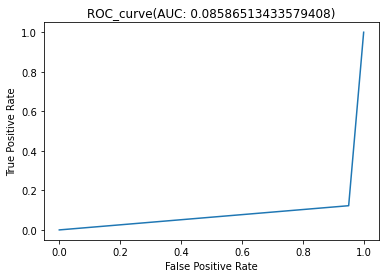

confusion matrix:


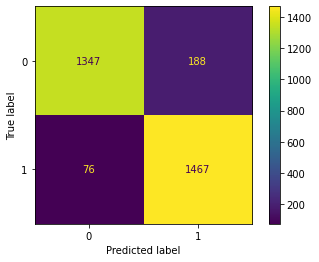

In [17]:
my_clf.fit(X_train, y_train)
y_pred = my_clf.predict(X_test)
print('Accuracy - ', accuracy_score(y_test, y_pred))
print('recall_score - ', recall_score(y_test, y_pred))
print('precision - ', precision_score(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)  
AUC = auc(fpr, tpr) 
plt.plot(fpr, tpr)  
plt.title('ROC_curve' + '(AUC: ' + str(AUC) + ')' )  
plt.ylabel('True Positive Rate')  
plt.xlabel('False Positive Rate')  
plt.show()
print('confusion matrix:')
matrix = confusion_matrix(y_test, y_pred)
plot = ConfusionMatrixDisplay(confusion_matrix=matrix)
plot.plot()

Как можем отметить, при использовании lr = 0.3 удалось построить наилучший классификатор и добиться улучшения точности на 2 процента.

In [18]:
joblib.dump(my_clf, "lin_reg.pkl")

['lin_reg.pkl']

In [19]:
clf = joblib.load("lin_reg.pkl")
y_pred = clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.9142300194931774

## Naive Bayes

In [20]:
from sklearn.naive_bayes import GaussianNB

In [21]:
class NaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.classes = None 
        self.n = 0
        self.mean = None
        self.var = None
        self.pri = None
        
    def fit(self, X, y):
        samples, features = X.shape
        self.classes = np.unique(y)
        self.n = len(self.classes)
        self.mean = np.zeros((self.n, features), dtype=np.float64)
        self.var = np.zeros((self.n, features), dtype=np.float64)
        self.pri = np.zeros(self.n, dtype=np.float64)
        
        for j in self.classes:
            X_ = X[j==y]
            self.mean[j-1] = X_.mean(axis=0)
            self.var[j-1] = X_.var(axis=0)
            self.pri[j-1] = X_.shape[0]/float(self.n)
            
    def func(self, idx, x):
        mean = self.mean[idx]
        var = self.var[idx]
        num = np.exp(- (x-mean)**2 / (2*var))
        denum = np.sqrt(2 * np.pi * var)
        k = num / denum
                
        return k
            
    def _predict(self, x):
        post = []
    
        for k in range(len(self.classes)):
            pri = np.log(self.pri[k])
            class_cond = np.sum(np.log(self.func(k, x)))
            poster = pri + class_cond
            post.append(poster)
            
        return self.classes[np.argmax(post)]
    
    def predict(self, X):
        pred = [self._predict(x) for x in X.to_numpy()]
        return pred

Составление Pipeline'ов для моего классификатора и коробочного классификатора Баевского метода

In [22]:
my_clf = Pipeline(
    [
        ("trans", SpInpTransformer(trans)),
        ("model",  NaiveBayes())
    ])

clf = Pipeline([
        ('trans', SpInpTransformer(trans)),     
        ('model', GaussianNB()) 
    ])

Моя модель

Accuracy -  0.8024691358024691
recall_score -  0.6592833876221499
precision -  0.9225159525979946


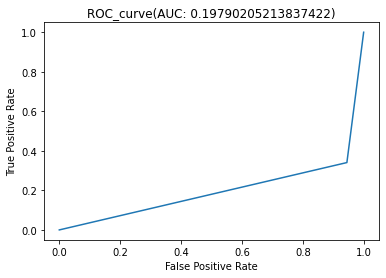

confusion matrix:


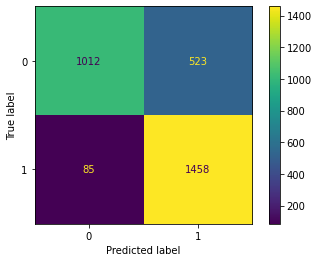

In [23]:
my_clf.fit(X_train, y_train)
y_pred = my_clf.predict(X_test)
print('Accuracy - ', accuracy_score(y_test, y_pred))
print('recall_score - ', recall_score(y_test, y_pred))
print('precision - ', precision_score(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)  
AUC = auc(fpr, tpr) 
plt.plot(fpr, tpr)  
plt.title('ROC_curve' + '(AUC: ' + str(AUC) + ')' )  
plt.ylabel('True Positive Rate')  
plt.xlabel('False Positive Rate')  
plt.show()
print('confusion matrix:')
matrix = confusion_matrix(y_test, y_pred)
plot = ConfusionMatrixDisplay(confusion_matrix=matrix)
plot.plot()

Коробочная модель Баевского метода

Accuracy -  0.8024691358024691
recall_score -  0.6592833876221499
precision -  0.9225159525979946


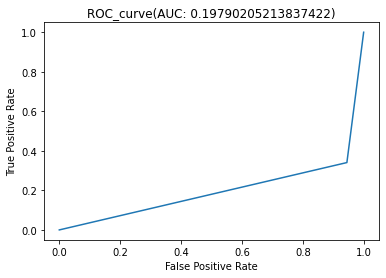

confusion matrix:


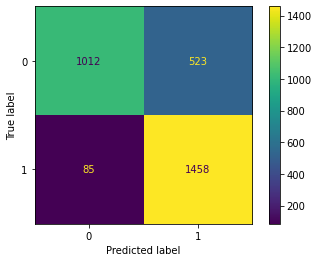

In [24]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy - ', accuracy_score(y_test, y_pred))
print('recall_score - ', recall_score(y_test, y_pred))
print('precision - ', precision_score(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)  
AUC = auc(fpr, tpr) 
plt.plot(fpr, tpr)  
plt.title('ROC_curve' + '(AUC: ' + str(AUC) + ')' )  
plt.ylabel('True Positive Rate')  
plt.xlabel('False Positive Rate')  
plt.show()
print('confusion matrix:')
matrix = confusion_matrix(y_test, y_pred)
plot = ConfusionMatrixDisplay(confusion_matrix=matrix)
plot.plot()

GridSeearchCV для поиска наилучших параметров

In [25]:
parameters = {
    'model__var_smoothing': np.logspace(0,-9, num=100)
}
grid_searcher = GridSearchCV(clf,  
                           param_grid = parameters,
                           cv = 5)
grid_searcher.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('trans',
                                        <__main__.SpInpTransformer object at 0x0000027C7587E220>),
                                       ('model', GaussianNB())]),
             param_grid={'model__var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])})

In [26]:
grid_searcher.best_params_

{'model__var_smoothing': 8.111308307896872e-05}

Accuracy -  0.8024691358024691
recall_score -  0.6592833876221499
precision -  0.9225159525979946


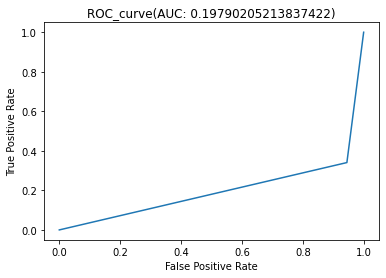

confusion matrix:


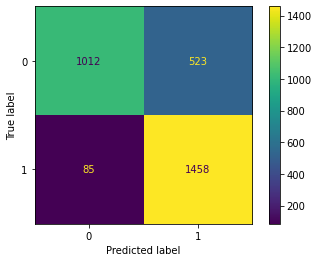

In [27]:
y_pred = grid_searcher.predict(X_test)
print('Accuracy - ', accuracy_score(y_test, y_pred))
print('recall_score - ', recall_score(y_test, y_pred))
print('precision - ', precision_score(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)  
AUC = auc(fpr, tpr) 
plt.plot(fpr, tpr)  
plt.title('ROC_curve' + '(AUC: ' + str(AUC) + ')' )  
plt.ylabel('True Positive Rate')  
plt.xlabel('False Positive Rate')  
plt.show()
print('confusion matrix:')
matrix = confusion_matrix(y_test, y_pred)
plot = ConfusionMatrixDisplay(confusion_matrix=matrix)
plot.plot()

Как можно заметить, точнось не улучшилась поэтому сохраню свой классификатор в формате pickle

In [28]:
joblib.dump(my_clf, "NB.pkl")

['NB.pkl']

In [29]:
clf = joblib.load("NB.pkl")
y_pred = clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.8024691358024691

## SVM

In [30]:
from sklearn.svm import SVC

In [31]:
class SVM(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.01, lamb=0.01, iters=1000):
        self.lr = lr
        self.lamb = lamb
        self.iters = iters
        self.w = None
        self.b = None
        self.n = 0
        self.m = 0
        
    def fit(self, X, y):
        self.n = y.max()
        self.m = y.min()
        y_ = np.where(y <= (self.n+self.m)/2, -1, 1)
        samples, features = X.shape
        self.w = np.zeros(features)
        self.b = 0
        
        for i in range(self.iters):
            for j, x_j in enumerate(X.to_numpy()):
                cond = y_[j] * (np.dot(x_j, self.w) - self.b) >= 1
                if cond:
                    self.w -= self.lr * (2 * self.lamb * self.w)
                else:
                    self.w -= self.lr * (2 * self.lamb * self.w - np.dot(x_j, y_[j]))
                    self.b -= self.lr * y_[j]
                    
    def predict(self, X):
        linear = np.sign(np.dot(X, self.w) - self.b)
        pred = np.where(linear <= 0, self.m, self.n)
        return pred

Составление Pipeline'ов для моего классификатора и коробочного классификатора SVM

In [32]:
my_clf = Pipeline(
    [
        ("trans", SpInpTransformer(trans)),
        ("model",  SVM())
    ])

clf = Pipeline([
        ('trans', SpInpTransformer(trans)),     
        ('model', SVC()) 
    ])

Моя модель

Accuracy -  0.9171539961013645
recall_score -  0.9022801302931596
precision -  0.9295302013422819


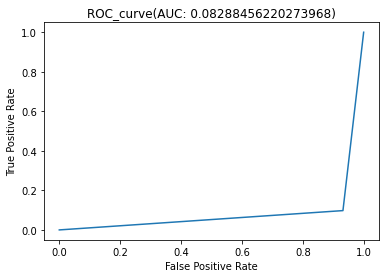

confusion matrix:


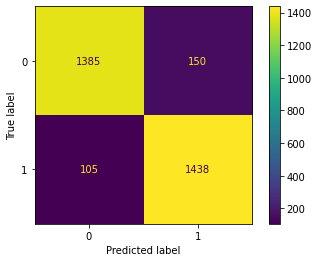

In [33]:
my_clf.fit(X_train, y_train)
y_pred = my_clf.predict(X_test)
print('Accuracy - ', accuracy_score(y_test, y_pred))
print('recall_score - ', recall_score(y_test, y_pred))
print('precision - ', precision_score(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)  
AUC = auc(fpr, tpr) 
plt.plot(fpr, tpr)  
plt.title('ROC_curve' + '(AUC: ' + str(AUC) + ')' )  
plt.ylabel('True Positive Rate')  
plt.xlabel('False Positive Rate')  
plt.show()
print('confusion matrix:')
matrix = confusion_matrix(y_test, y_pred)
plot = ConfusionMatrixDisplay(confusion_matrix=matrix)
plot.plot()

Коробочная модель SVM(SVC)

Accuracy -  0.9632878492527616
recall_score -  0.9680781758957655
precision -  0.9587096774193549


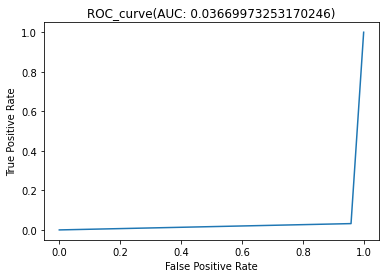

confusion matrix:


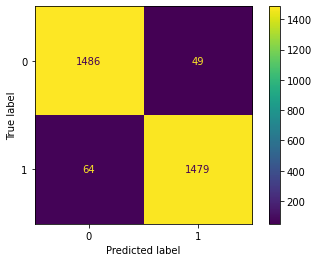

In [34]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy - ', accuracy_score(y_test, y_pred))
print('recall_score - ', recall_score(y_test, y_pred))
print('precision - ', precision_score(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)  
AUC = auc(fpr, tpr) 
plt.plot(fpr, tpr)  
plt.title('ROC_curve' + '(AUC: ' + str(AUC) + ')' )  
plt.ylabel('True Positive Rate')  
plt.xlabel('False Positive Rate')  
plt.show()
print('confusion matrix:')
matrix = confusion_matrix(y_test, y_pred)
plot = ConfusionMatrixDisplay(confusion_matrix=matrix)
plot.plot()

GridSearchCV для SVM

In [35]:
param_grid = {'model__C':[0.1, 1, 10, 100],}
grid_searcher = GridSearchCV(clf,  param_grid, cv = 5)
grid_searcher.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('trans',
                                        <__main__.SpInpTransformer object at 0x0000027C75AE4BB0>),
                                       ('model', SVC())]),
             param_grid={'model__C': [0.1, 1, 10, 100]})

In [36]:
grid_searcher.best_params_

{'model__C': 1}

Accuracy -  0.9632878492527616
recall_score -  0.9680781758957655
precision -  0.9587096774193549


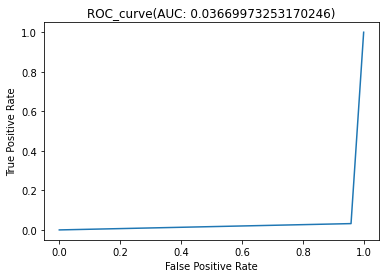

confusion matrix:


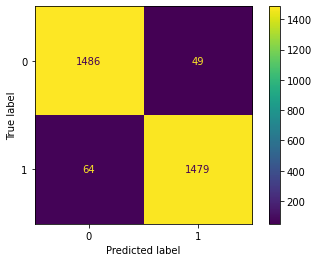

In [37]:
y_pred = grid_searcher.predict(X_test)
print('Accuracy - ', accuracy_score(y_test, y_pred))
print('recall_score - ', recall_score(y_test, y_pred))
print('precision - ', precision_score(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)  
AUC = auc(fpr, tpr) 
plt.plot(fpr, tpr)  
plt.title('ROC_curve' + '(AUC: ' + str(AUC) + ')' )  
plt.ylabel('True Positive Rate')  
plt.xlabel('False Positive Rate')  
plt.show()
print('confusion matrix:')
matrix = confusion_matrix(y_test, y_pred)
plot = ConfusionMatrixDisplay(confusion_matrix=matrix)
plot.plot()

Наилучшим оказался коробочный классификатор, сохраним его

In [38]:
joblib.dump(grid_searcher, "SVM.pkl")

['SVM.pkl']

In [39]:
clf = joblib.load("SVM.pkl")
y_pred = clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.9632878492527616

## KNN

In [40]:
from sklearn.neighbors import KNeighborsClassifier

In [41]:
class KNN(BaseEstimator, ClassifierMixin):
    def __init__(self, n_val=5):
        self.n_val = n_val
        self.train = None
        self.validation = None

    def fit(self, X, y):
        self.train = X
        self.validation = y
        
    def predict(self, X):
        prediction = []
        j = 1
        n = len(X)
        for y_test in X.to_numpy():
            distance = []
            for i in range(len(self.train)):
                distance.append(np.linalg.norm(np.array(self.train.iloc[i]) - y_test))
                
            distance_data = pd.DataFrame(data = distance, columns = ['dist'], index = self.validation.index)
            neighbours = distance_data.sort_values(by='dist', axis=0)[:self.n_val]
            
            labels = self.validation.loc[neighbours.index]
            vote = mode(labels).mode[0]
            
            prediction.append(vote)
            j+=1
            
        return prediction

Составление Pipeline'ов для моего классификатора и коробочного классификатора KNN

In [42]:
my_clf = Pipeline(
    [
        ("trans", SpInpTransformer(trans)),
        ("model", KNN())
    ])

clf = Pipeline([
        ('trans', SpInpTransformer(trans)),     
        ('knn', KNeighborsClassifier(algorithm='brute')) 
    ])

Моя модель

Использовал на малом числе тестовых значений, потому что работал долго

Accuracy -  0.955
recall_score -  0.9489795918367347
precision -  0.9587628865979382


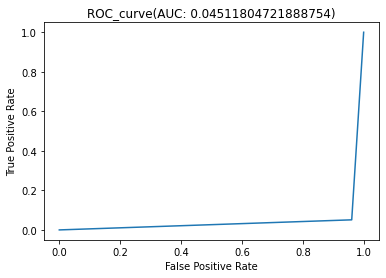

confusion matrix:


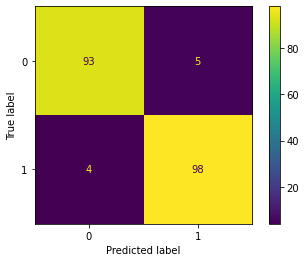

In [43]:
my_clf.fit(X_train, y_train)
y_pred = my_clf.predict(X_test[:200])
print('Accuracy - ', accuracy_score(y_test[:200], y_pred))
print('recall_score - ', recall_score(y_test[:200], y_pred))
print('precision - ', precision_score(y_test[:200], y_pred))
fpr, tpr, thresholds = roc_curve(y_test[:200], y_pred, pos_label=1)  
AUC = auc(fpr, tpr) 
plt.plot(fpr, tpr)  
plt.title('ROC_curve' + '(AUC: ' + str(AUC) + ')' )  
plt.ylabel('True Positive Rate')  
plt.xlabel('False Positive Rate')  
plt.show()
print('confusion matrix:')
matrix = confusion_matrix(y_test[:200], y_pred)
plot = ConfusionMatrixDisplay(confusion_matrix=matrix)
plot.plot()

Коробочная модель KNN

Accuracy -  0.955
recall_score -  0.9489795918367347
precision -  0.9587628865979382


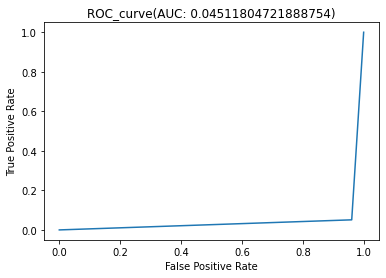

confusion matrix:


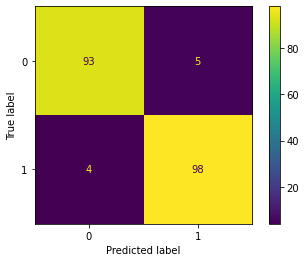

In [44]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test[:200])
print('Accuracy - ', accuracy_score(y_test[:200], y_pred))
print('recall_score - ', recall_score(y_test[:200], y_pred))
print('precision - ', precision_score(y_test[:200], y_pred))
fpr, tpr, thresholds = roc_curve(y_test[:200], y_pred, pos_label=1)  
AUC = auc(fpr, tpr) 
plt.plot(fpr, tpr)  
plt.title('ROC_curve' + '(AUC: ' + str(AUC) + ')' )  
plt.ylabel('True Positive Rate')  
plt.xlabel('False Positive Rate')  
plt.show()
print('confusion matrix:')
matrix = confusion_matrix(y_test[:200], y_pred)
plot = ConfusionMatrixDisplay(confusion_matrix=matrix)
plot.plot()

GridSearchCV для KNN

In [45]:
params = {
    'knn__n_neighbors': [3, 5, 7, 9, 11]
}
grid_searcher = GridSearchCV(estimator=clf, param_grid=params, cv=5, return_train_score=True)

In [46]:
grid_searcher.fit(X_train, y_train)
grid_searcher.best_params_

{'knn__n_neighbors': 7}

Accuracy -  0.9506172839506173
recall_score -  0.9433224755700326
precision -  0.9570389953734303


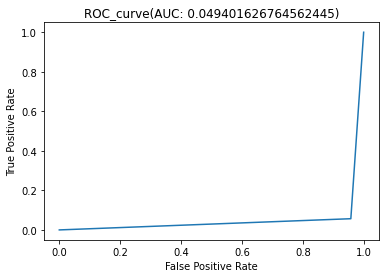

confusion matrix:


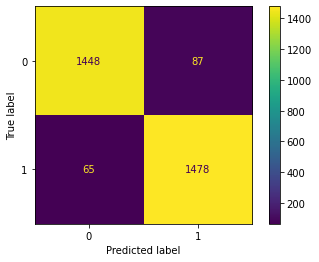

In [47]:
y_pred = grid_searcher.predict(X_test)
print('Accuracy - ', accuracy_score(y_test, y_pred))
print('recall_score - ', recall_score(y_test, y_pred))
print('precision - ', precision_score(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)  
AUC = auc(fpr, tpr) 
plt.plot(fpr, tpr)  
plt.title('ROC_curve' + '(AUC: ' + str(AUC) + ')' )  
plt.ylabel('True Positive Rate')  
plt.xlabel('False Positive Rate')  
plt.show()
print('confusion matrix:')
matrix = confusion_matrix(y_test, y_pred)
plot = ConfusionMatrixDisplay(confusion_matrix=matrix)
plot.plot()

На испытании на тестовых данных с 7 ближайшими соседями выдал тоже хороший результат, сохраним его

In [48]:
joblib.dump(grid_searcher, "KNN.pkl")

['KNN.pkl']

In [49]:
clf = joblib.load("KNN.pkl")
y_pred = clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.9506172839506173

## Вывод лабораторной работы 1

###### В данной части лабораторной работы мной были изучены и составлены 4 предложенных классификатора. С помощью их удалось добиться хороших результатов. Все результаты больше 80. Также был изучен pipeline, который позволяет создавать последовательные стадии использования классификатора (pre-processing, classification ...). Во время выполнения работы также использовал метод GridSearchCV, для определения лучших параметров и использовании кросс-валидации. В результате чего, удалось добиться еще более лучших результатов даже 95 %. Наилушие классификаторы были сохранены в файл формата pickle. 